### This script is intended for variable importance identification and error metrics recording. Enter variables being tested in the cell below and re-run the entire script.
#### emis:
ACET            ACROLEIN        ALD2            ALD2_PRIMARY    ALDX            APIN            BENZ            BPIN            BUTADIENE13     CH4             CH4_INV         CL2             CO              CO2_INV         ETH             ETHA            ETHY            ETOH            FORM            FORM_PRIMARY    HCL             HONO            IOLE            ISOP            KET             MEOH            N2O_INV         NAPH            NH3             NH3_FERT        NO              NO2             NR              NVOL            OLE             PAL             PAR             PCA             PCL             PEC             PFE             PH2O            PK              PMC             PMG             PMN             PMOTHR          PNA             PNCOM           PNH4            PNO3            POC             PRPA            PSI             PSO4            PTI             SESQ            SO2             SOAALK          SULF            TERP            TOL             UNK             UNR             VOC_BEIS        VOC_INV         XYLMN

#### met: 
PRSFC           USTAR           WSTAR           PBL             ZRUF            MOLI            HFX             LH              RADYNI          RSTOMI          TEMPG           TEMP2           Q2              WSPD10          WDIR10          GLW             GSW             RGRND           RN              RC              CFRAC           CLDT            CLDB            WBAR            SNOCOV          VEG             LAI             SEAICE          SNOWH           WR              SOIM1           SOIM2           SOIT1           SOIT2           SLTYP           WSAT_PX         WFC_PX          WWLT_PX         CSAND_PX 

In [89]:
emis_variables = ['NO', 'NO2', 'CH4', 'VOC_BEIS', 'VOC_INV']
met_variables = ['TEMP2', 'WSPD10','WDIR10', 'Q2', 'RC', 'GSW'] 

In [90]:
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import numpy as np
import math
import csv
import os
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import clear_output
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.utils import np_utils
import copy

In [91]:
# Configuration
analyze = False
save_to_file = False
read_from_file = False
create_plots = True

In [92]:
def get_file_list(data_dir):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir)]


aq_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/aq_conc/'
emis_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/emis_data/'
met_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/met_data/'

aq_files = get_file_list(aq_dir)
emis_files = get_file_list(emis_dir)
met_files = get_file_list(met_dir)

In [93]:
#Input Data
conc_data = netCDF4.MFDataset(aq_files)#concentrations 
o3_data = conc_data['O3']
emis_data = netCDF4.MFDataset(emis_files) #emissions 
met_data = netCDF4.MFDataset(met_files)#Met

#Monitor_Locations
monitors_file = 'C:/Users/woshi/Desktop/CE_675_Project/Data/loc_data/monitor_list_NC.csv'
with open(monitors_file) as csvfile:
    reader = csv.DictReader(csvfile)
    monitor_points = [(int(float(row['Col'])), int(float(row['Row'] ))) for row in reader if row['Col']]

monitors_x, monitors_y = zip(*monitor_points)

In [94]:
training_params = {
                   'd' : 1, #local_emissions_size
                   'emis_species': emis_variables, #emission_species
                   'met_params':met_variables, #met parameters
                   'emis_data': emis_data,
                   'met_data':met_data,
                   'conc_data': o3_data,
                   'monitor_points':monitor_points
                 }
## Random points for testing/performance evaluation
np.random.seed(1977)
num_points = 300

#No. of periods in each training sequence
sequence_size = 24

In [95]:
def get_random_domain_points(num_points, domain_params):
    x_points = np.random.normal(domain_params['x_center'], 
                                domain_params['x_std'],
                                num_points)
    
    y_points = np.random.normal(domain_params['y_center'], 
                                domain_params['y_std'],
                               num_points)

    def threshold_points(x,maxx,minn):
        return x[(x<maxx) & (x>minn)]

    x_p = map(int,threshold_points(x_points,domain_params['x_max'], domain_params['x_min']))
    y_p = map(int,threshold_points(y_points,domain_params['y_max'], domain_params['y_min']))
    return list(set(zip(x_p, y_p)))
    


domain_params = {
    'x_center': 65, 'x_std' : 15, 'x_max': 180, 'x_min' : 0,
    'y_center' : 125,'y_std' : 15,'y_max': 180, 'y_min':0    
}

if not read_from_file:
    print('Generating random points for training and testing')
    pxy = get_random_domain_points(num_points,domain_params)

Generating random points for training and testing


In [96]:
def dist_predictors(x,y, monitor_points,centroid=True,**kwargs):
    
    x_centroid = np.average([point[0] for point in monitor_points])
    y_centroid = np.average([point[1] for point in monitor_points])
   
    def unit_vector(vector):
        return vector / np.linalg.norm(vector)

    def angle_between(v1, v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    if centroid:   
        distance = math.sqrt((x_centroid - x)**2 + (y_centroid -y)**2)
        v1 = (x_centroid, y_centroid)
        v2 = (x,y)
        angle = angle_between(v1,v2)
        return np.array([distance, angle])
    else:
        
        distances =[math.sqrt((x - point[0])**2 + (y - point[1])**2) for point in monitor_points]
        angles = [angle_between((x,y), (point[0], point[1])) for point in monitor_points]
        da = distances + angles
        return np.array(da) 

In [97]:
def emis_predictors(x,y,tlist, d, emis_data, emis_species, **kwargs):

    xs = np.arange(-d,d+1) + x
    ys = np.arange(-d,d+1) + y
    num_cells = len(xs)*len(ys)

    dummy = np.arange(1)
    grid = np.ix_(tlist,dummy,xs,ys)
    
    def get_emis_slice(emis_data,species):
        e1 = emis_data[species][:]
        e2 = e1[grid]
        return e2.reshape(len(tlist), num_cells)

    emis_seq = [ get_emis_slice(emis_data, species) for species in emis_species] 
    return np.concatenate(emis_seq,axis=1)    

def history_monitors_predictors(t,conc_data, monitor_points, **kwargs):

    monitors_x, monitors_y = zip(*monitor_points) 
    concs = conc_data[t][:,0,monitors_x,monitors_y]

    return concs

def met_predictors(t,monitor_points, met_data, met_params, **kwargs):
   
    monitors_x, monitors_y = zip(*monitor_points) 
    
    met_seq = []
    for param in met_params:
        m1 = met_data[param][:]
        m2 = m1[t][:,0,monitors_x,monitors_y]
        #print(m2)
        #print(m2.shape)
        met_seq.append(m2)
    return np.concatenate(met_seq, axis=1)

In [98]:
def get_predictors_xyt(p,tlist,training_params,debug=False):
    
    x = p[0]
    y = p[1]

    dist = dist_predictors(x,y,**training_params) #time invariant
    dist_tile = np.tile(dist,(len(tlist),1))

    emis = emis_predictors(x,y,tlist,**training_params)
    met  = met_predictors(tlist,**training_params)
    hist = history_monitors_predictors(tlist,**training_params)
    
    try:
        preds = np.concatenate([dist_tile, emis, hist,met], axis=1)
        return preds
    except:
        return [dist_tile,emis,hist,met]

def get_Xy(pxy, hour_begin_seq, training_params):
    from itertools import product, repeat

    predictors = {}
    aq = {}
    conc_data =training_params['conc_data']
    pxy_time = [i for i in product(pxy,hour_begin_seq)]
    for pt in tqdm(pxy_time, desc='Seq Processed'):
        point = pt[0]
        hour_begin = pt[1]
        tlist = [i for i in range(hour_begin - sequence_size, hour_begin)]
        predictors[pt] = get_predictors_xyt(point,tlist,training_params,debug=False)
        
        hour_next = hour_begin + 1
        aq[pt] = conc_data[hour_next, 0, point[0], point[1]]
    
    return predictors, aq

In [99]:
hour_begin_seq_split = [0,6,12,18,24,30,36,42,48,54,60]

if not read_from_file:
    predictors, aq = get_Xy(pxy, hour_begin_seq_split,training_params)    
    print ('\n Done getting predictors')

<ipython-input-98-37d2517c603a>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pt in tqdm(pxy_time, desc='Seq Processed'):




 Done getting predictors


In [100]:
def get_splits(predictors,train_fraction=0.95):
    num_predictors = len(predictors)
    pxy = list(predictors.keys())

    num_train = int(train_fraction*num_predictors)
    train_indices = np.random.choice(np.arange(num_predictors),num_train, replace=False)
    pxy_train = [pxy[i] for i in train_indices]
    predictors_train = [predictors[i] for i in pxy_train]
    aq_train = [aq[i] for i in pxy_train]
    print ('number of training points', num_train, '&', len(predictors_train))

    #Random sample for Testing
    predictors_test = [predictors[i] for i in pxy if i not in pxy_train]
    aq_test = [aq[i] for i in pxy if i not in pxy_train]
    pxy_test = [i for i in pxy if i not in pxy_train]
    print('number of testing points', len(predictors_test), '&', len(aq_test))
    return predictors_train, aq_train, predictors_test, aq_test

if not read_from_file:
    print('Getting train and test splits')
    predictors_train, aq_train, predictors_test, aq_test = get_splits(predictors)

Getting train and test splits
number of training points 3030 & 3030
number of testing points 160 & 160


In [101]:
if not read_from_file:

    print('scaling inputs and outputs')
    from sklearn.preprocessing import MinMaxScaler

    data = np.concatenate(list(predictors.values()))
    pred_scaler = MinMaxScaler()
    pred_scaler.fit(data)

    aq_data = np.stack(aq.values()).reshape(-1,1)
    aq_scaler = MinMaxScaler()
    aq_scaler.fit(aq_data)

    predictors_train_scaled = [pred_scaler.transform(mx) for mx in predictors_train]
    predictors_train_rnn = np.stack(predictors_train_scaled)
    aq_train_rnn = aq_scaler.transform(np.stack(aq_train).reshape(-1,1))

    predictors_test_scaled = [pred_scaler.transform(mx) for mx in predictors_test]
    predictors_test_rnn = np.stack(predictors_test_scaled)
    aq_test_rnn = aq_scaler.transform(np.stack(aq_test).reshape(-1,1))

### Save for future use.
predictors_file = 'C:/Users/woshi/Desktop/CE_675_Project/Data/saved_data/'

if save_to_file == True:
    #data_to_save = [predictors_train_rnn, aq_train, predictors_test_rnn,aq_test] 

    np.savez(predictors_file, predictors_train_rnn = predictors_train_rnn, #X_train, shape=(samples,tsteps,features)
                              aq_train_rnn = aq_train_rnn, #y_train
                              predictors_test_rnn = predictors_test_rnn, #X_test
                              aq_test_rnn = aq_test_rnn #y_test
            )

scaling inputs and outputs


C:\Users\woshi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [102]:
s0,s1,s2=predictors_train_rnn.shape
print ('shape of x_train data', s0,s1,s2)
print ('shape of y_train data', aq_train_rnn.shape)

shape of x_train data 3030 24 327
shape of y_train data (3030, 1)


In [103]:
# Design Network
m = Sequential()
m.add(LSTM(128,input_shape=predictors_train_rnn.shape[1:], return_sequences=True, activation='tanh'))
m.add(LSTM(128, activation='tanh'))
m.add(Dropout(0.50))
m.add(Dense(128, activation='tanh'))
m.add(Dense(1))
m.compile(loss='mean_squared_error',optimizer='adam')

In [104]:
print(m.summary())
print("Inputs: {}".format(m.input_shape))
print( "Outputs: {}".format(m.output_shape))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 128)           233472    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 381,697
Trainable params: 381,697
Non-trainable params: 0
_________________________________________________________________
None
Inputs: (None, 24, 327)
Outputs: (None, 1)


In [105]:
history = m.fit(predictors_train_rnn, aq_train_rnn, epochs=100, 
                    validation_data=(predictors_test_rnn, aq_test_rnn), verbose=2, shuffle=True
               )

Epoch 1/100
95/95 - 3s - loss: 0.0485 - val_loss: 0.0195
Epoch 2/100
95/95 - 3s - loss: 0.0173 - val_loss: 0.0171
Epoch 3/100
95/95 - 3s - loss: 0.0158 - val_loss: 0.0143
Epoch 4/100
95/95 - 3s - loss: 0.0145 - val_loss: 0.0143
Epoch 5/100
95/95 - 3s - loss: 0.0144 - val_loss: 0.0145
Epoch 6/100
95/95 - 3s - loss: 0.0135 - val_loss: 0.0163
Epoch 7/100
95/95 - 4s - loss: 0.0134 - val_loss: 0.0151
Epoch 8/100
95/95 - 5s - loss: 0.0131 - val_loss: 0.0136
Epoch 9/100
95/95 - 4s - loss: 0.0125 - val_loss: 0.0141
Epoch 10/100
95/95 - 4s - loss: 0.0130 - val_loss: 0.0132
Epoch 11/100
95/95 - 5s - loss: 0.0125 - val_loss: 0.0140
Epoch 12/100
95/95 - 4s - loss: 0.0123 - val_loss: 0.0140
Epoch 13/100
95/95 - 4s - loss: 0.0131 - val_loss: 0.0139
Epoch 14/100
95/95 - 4s - loss: 0.0121 - val_loss: 0.0136
Epoch 15/100
95/95 - 4s - loss: 0.0121 - val_loss: 0.0140
Epoch 16/100
95/95 - 4s - loss: 0.0122 - val_loss: 0.0138
Epoch 17/100
95/95 - 4s - loss: 0.0116 - val_loss: 0.0133
Epoch 18/100
95/95 - 5s

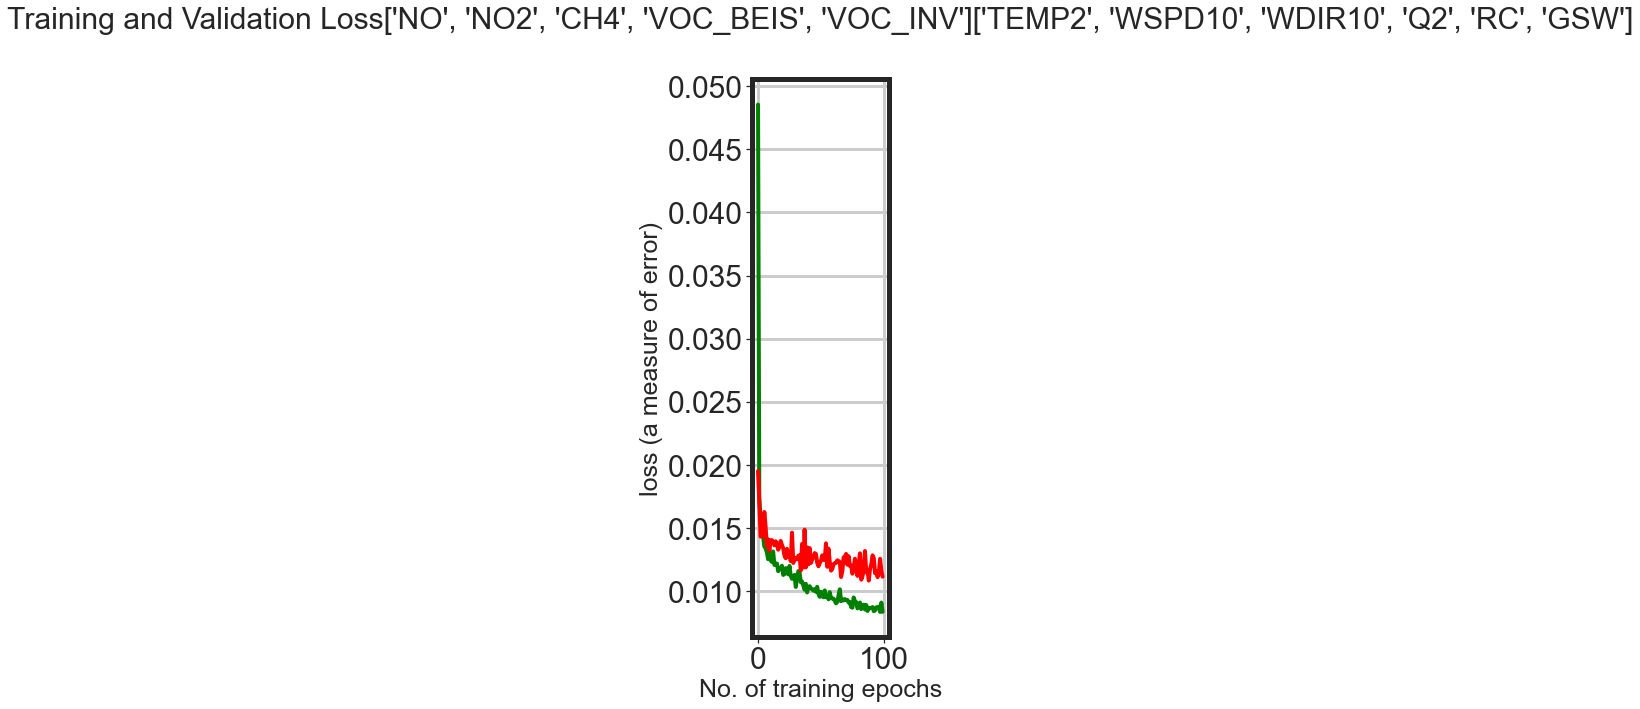

In [106]:
sns.set_style('ticks')
plt.rcParams['axes.linewidth'] = 5

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1)
p1 = ax.plot(history.history['loss'], linewidth=4, color ='green')
p2 = ax.plot(history.history['val_loss'], linewidth=4, color ='red')

ax.set_ylabel('loss (a measure of error)', fontdict={'fontsize':25})
ax.set_xlabel('No. of training epochs', fontdict={'fontsize':25})
ax.set_title('Training and Validation Loss'+str(emis_variables)+str(met_variables), fontdict={'fontsize':30}, y=1.08)
ax.tick_params(axis='both', labelsize=30)
ax.grid(axis='both', linewidth=3)
fig.tight_layout()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/importance_identification/trn_val_loss'+
            str(emis_variables)+str(met_variables)+'.pdf', format='pdf', dpi=1200)

In [107]:
test_predict = m.predict(predictors_test_rnn)

test_predict_descaled = aq_scaler.inverse_transform(test_predict)
aq_test_rnn_descaled = aq_scaler.inverse_transform(aq_test_rnn)

<ipython-input-108-eb44b40dc057>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


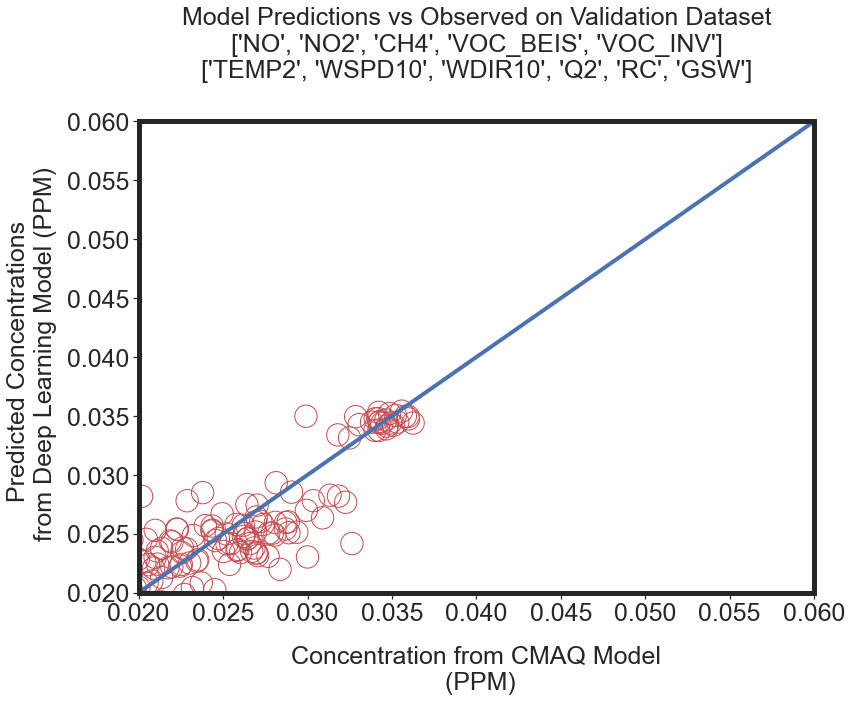

In [108]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['axes.linewidth'] = 5
ax = fig.add_subplot(1,1,1)
p1 = ax.scatter(aq_test_rnn_descaled, test_predict_descaled, edgecolors='r', facecolor="none", s=500, linewidths=1)
ax.set_xlim([0.02,0.06])
ax.set_ylim([0.02,0.06])
ax.set_ylabel('Predicted Concentrations \n from Deep Learning Model (PPM)', fontdict={'fontsize':25}, labelpad=10)
ax.set_xlabel('Concentration from CMAQ Model\n (PPM)', fontdict={'fontsize':25}, labelpad=20)
ax.set_title('Model Predictions vs Observed on Validation Dataset\n'+str(emis_variables)+'\n'+str(met_variables)
             , fontdict={'fontsize':25},y=1.08)

ax.plot([0.01,0.09], [0.01,0.09], linewidth=4)
ax.tick_params(axis='both', labelsize=25)
fig.tight_layout()
fig.show()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/importance_identification/pdct_val'+
            str(emis_variables)+str(met_variables)+'.pdf', format='pdf', dpi=1200)

In [109]:
pxy_future = pxy = get_random_domain_points(50,domain_params)
hour_begin_seq = [66,72,78,84]
    
if not read_from_file:
    predictors_future, aq_future = get_Xy(pxy, hour_begin_seq, training_params)    
    print ('\n Done getting predictors')

## Scale, Predict, and Descale:
def get_model_predictions(model, X_as_dict, X_scaler, y_scaler):
    
    X = list(X_as_dict.values())
    X_temp = [X_scaler.transform(mx) for mx in X]
    X_scaled = np.stack(X_temp)
    y_scaled = model.predict(X_scaled)
    return y_scaler.inverse_transform(y_scaled)

y_model_predicted = get_model_predictions(m, predictors_future, pred_scaler, aq_scaler)
y = np.stack(aq_future.values()).reshape(-1,1)

<ipython-input-98-37d2517c603a>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pt in tqdm(pxy_time, desc='Seq Processed'):




 Done getting predictors


C:\Users\woshi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


<ipython-input-110-a456bff764c0>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


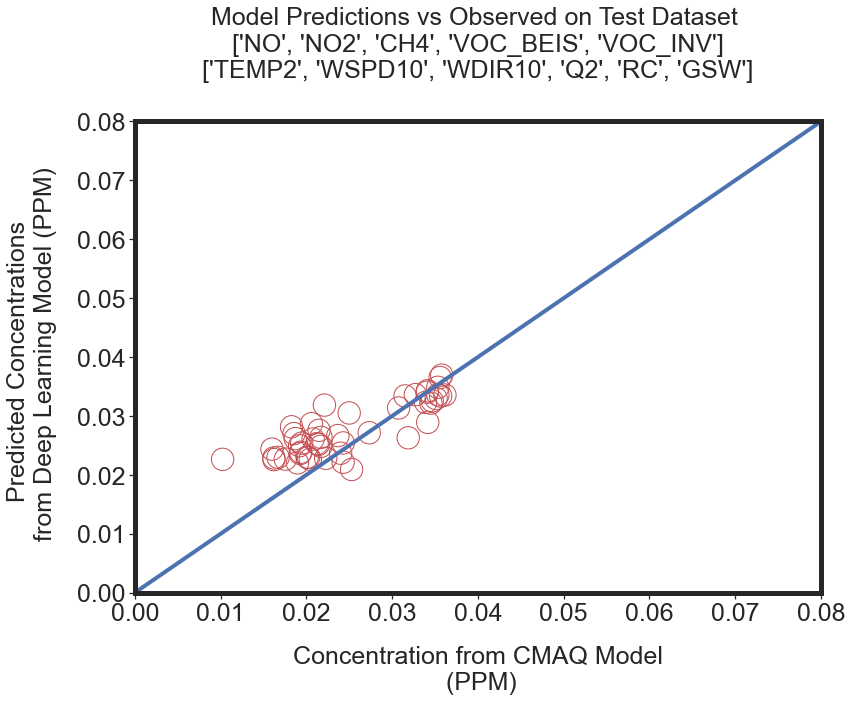

In [110]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['axes.linewidth'] = 5
ax = fig.add_subplot(1,1,1)
p1 = ax.scatter(y[0:50], y_model_predicted[0:50], edgecolors='r', facecolor="none", s= 500, linewidths=1)
ax.set_xlim([0.00,0.08])
ax.set_ylim([0.00,0.08])
ax.set_ylabel('Predicted Concentrations \n from Deep Learning Model (PPM)', fontdict={'fontsize':25}, labelpad=20)
ax.set_xlabel('Concentration from CMAQ Model\n (PPM)', fontdict={'fontsize':25}, labelpad=20)
ax.set_title('Model Predictions vs Observed on Test Dataset \n'+str(emis_variables) +'\n' +str(met_variables)
             , fontdict={'fontsize':25},y=1.08)

ax.plot([0.00,0.09], [0.00,0.09], linewidth=4)
ax.tick_params(axis='both', labelsize=25)
fig.tight_layout()
fig.show()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/importance_identification/pdct_test'+
            str(emis_variables)+str(met_variables)+'.pdf', format='pdf', dpi=1200)

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

MAE = mean_absolute_error(test_predict_descaled, aq_test_rnn_descaled)
print('MAE is {:.2} PPM'.format(MAE))

MSE = mean_squared_error(test_predict_descaled, aq_test_rnn_descaled)
#print('MSE is {} PPM'.format(MSE))

RMSE = np.sqrt(MSE)
print('RMSE is {:.2} PPM'.format(RMSE))

Percentage = RMSE/aq_test_rnn_descaled.mean()
print('Percent of RMSE to Mean AQ {:.1%}'.format(Percentage))

RMSE_test = np.sqrt(mean_squared_error(y, y_model_predicted))

import datetime
ISOTIMEFORMAT = '%Y-%m-%d %H:%M:%S'
theTime = datetime.datetime.now().strftime(ISOTIMEFORMAT)

MAE is 0.0024 PPM
RMSE is 0.0033 PPM
Percent of RMSE to Mean AQ 13.3%


In [112]:
this_results = [emis_variables, met_variables, hour_begin_seq_split, len(hour_begin_seq_split), MAE, RMSE, Percentage, RMSE_test, theTime]
record = open('C:/Users/woshi/Desktop/CE_675_Project/importance_identification/record.csv', "a", newline='')
writer = csv.writer(record)
writer.writerow(this_results)
record.close()

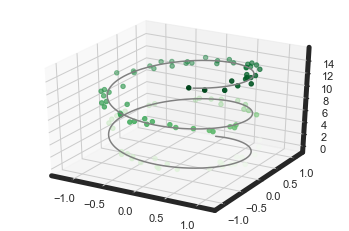

In [113]:
#绘制三角螺旋线
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

#三维线的数据
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# 三维散点的数据
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')